In [1]:
# Imports and declarations
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["image.cmap"] = "binary_r"
import sys
sys.path.append("../../semi-supervised")

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
cuda = torch.cuda.is_available()

# Variational AutoEncoder

This notebook shows how to use a Variational AutoEncoder to model the data distribution over MNIST-digits $p(x)$. We will then learn a latent distribution $q_{\theta}(z \mid x)$ based on the digits. The M1 model in (Kingma 2014) describes the semi-supervised classifier as mapping latent representations to their label using a classifier.

In [2]:
flatten_bernoulli = lambda img: transforms.ToTensor()(img).view(-1).bernoulli()

mnist = datasets.MNIST('./', train=True, download=True, transform=flatten_bernoulli)
mnist_val = datasets.MNIST('./', train=False, download=True, transform=flatten_bernoulli)

unlabelled = torch.utils.data.DataLoader(mnist, batch_size=100, shuffle=True, num_workers=2)
validation = torch.utils.data.DataLoader(mnist_val, batch_size=100, shuffle=True, num_workers=2)

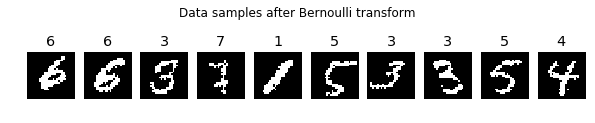

In [3]:
f, axarr = plt.subplots(1, 10, figsize=(10, 2))
images, labels = next(iter(unlabelled))

for i in range(10):
    axarr[i].imshow(images[i].numpy().reshape(28, 28))
    axarr[i].set_title(labels[i])
    axarr[i].axis("off")
    
f.suptitle("Data samples after Bernoulli transform")
plt.show()

The variational autoencoder is defined in terms of its input dimensionality along with the dimensionality of the latent space. In this example we have exactly one hidden layer both the encoder and decoder with 128 neurons. In order to train the model, we use variational inference by fitting a variational distribution $q(z | X)$ to the encoder. The full objective is given by: 

$${\mathcal {L}}(\phi,\theta, X) = D_{KL}(q_{\phi}( z | X ) \ || \ p(z))-\mathbb {E}_{q_{\phi }(z |X )}\log p_{\theta }(X | z )$$

Where $\phi$ and $\theta$ are parameters of the encoder and decoder network respectively. The objective means that we want to make maximise the models ability to recreate the input given a learned latent representation $x$ while keeping $q(z | X)$ similar to some known distribution.

For this problem we choose $q(z | X)$ to be similar to a standard normal distribution by using `kl_divergence_normal` and we measure the pixelwise binary cross entropy as our likelihood function. This leads to the model and loss function as below.

In [4]:
from models.vae import VariationalAutoencoder
from inference.loss import VariationalInference

model = VariationalAutoencoder([28*28, 2, [128]])

if cuda: model = model.cuda()

    
objective = VariationalInference(F.binary_cross_entropy)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

model

VariationalAutoencoder (
  (encoder): Encoder (
    (hidden): ModuleList (
      (0): Linear (784 -> 128)
    )
    (sample): StochasticGaussian (
      (mu): Linear (128 -> 2)
      (log_var): Linear (128 -> 2)
    )
  )
  (decoder): Decoder (
    (hidden): ModuleList (
      (0): Linear (2 -> 128)
    )
    (reconstruction): Linear (128 -> 784)
    (output_activation): Sigmoid ()
  )
)

In [8]:
from trainers import VAETrainer

trainer = VAETrainer(model, objective, optimizer)
trainer.train(unlabelled, unlabelled, 100)

{'epoch': 0, 'Loss': 0.837973952293396}
{'epoch': 5, 'Loss': 0.3850899636745453}
{'epoch': 10, 'Loss': 0.3079211413860321}
{'epoch': 15, 'Loss': 0.24709007143974304}
{'epoch': 20, 'Loss': 0.27694398164749146}
{'epoch': 25, 'Loss': 0.28335437178611755}
{'epoch': 30, 'Loss': 0.2652028501033783}
{'epoch': 35, 'Loss': 0.25764915347099304}
{'epoch': 40, 'Loss': 0.26334598660469055}
{'epoch': 45, 'Loss': 0.2707723379135132}
{'epoch': 50, 'Loss': 0.2804625928401947}
{'epoch': 55, 'Loss': 0.26596489548683167}
{'epoch': 60, 'Loss': 0.25262296199798584}
{'epoch': 65, 'Loss': 0.26273098587989807}
{'epoch': 70, 'Loss': 0.2743067741394043}
{'epoch': 75, 'Loss': 0.2430611401796341}
{'epoch': 80, 'Loss': 0.25654199719429016}
{'epoch': 85, 'Loss': 0.26176369190216064}
{'epoch': 90, 'Loss': 0.258696585893631}
{'epoch': 95, 'Loss': 0.2705790102481842}


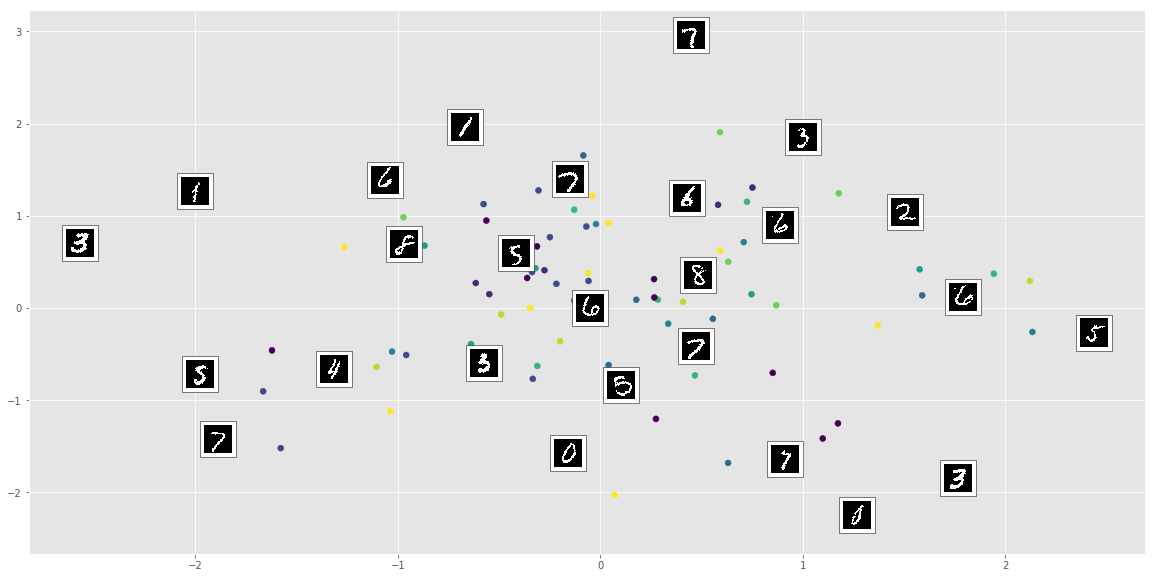

In [28]:
x, labels = next(iter(unlabelled))

reconstruction, [z, z_mu, z_log_var] = model(Variable(x))

projection = z.data.numpy()
images = x.numpy().reshape(-1, 28, 28)
fraction = 0.3

from plotutils import plot_latent

plot_latent(projection, images, labels.numpy(), fraction)
plt.show()

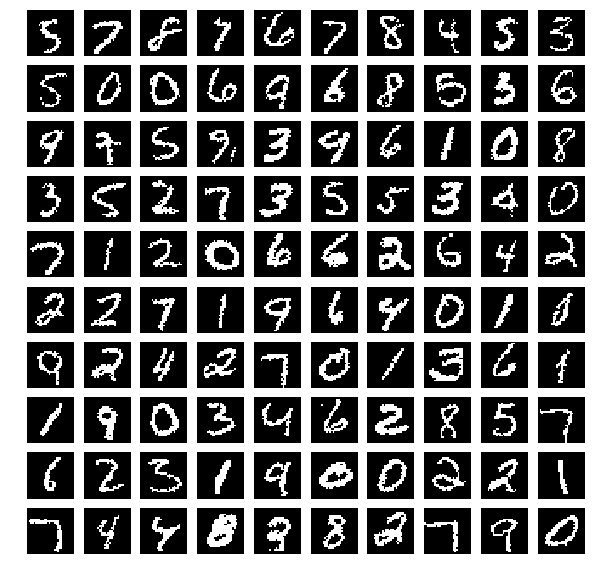

In [31]:
from torch.autograd import Variable

z = torch.randn(16, 2)
z = torch.from_numpy(np.tile(np.linspace(-2, 2, 100), 2).reshape(-1, 2)).type(torch.FloatTensor)

samples = model.sample(Variable(z))
samples = samples.data.numpy().reshape(-1, 28, 28)

f, axarr = plt.subplots(10, 10, figsize=(10, 10))

for i in range(100):
    axarr[i//10, i%10].imshow(samples[i])
    axarr[i//10, i%10].axis("off")

plt.show()

## Classification

Now that we have constructed a distribution $p(z | x)$ and are able to transform our data $x$ into latent representation $z$, we can perform classification. In Kingma 2014, it is suggested to use an SVM. We will instead use a simple multilayer perceptron, which should work as the latent space is of lower dimensionality than the input space.

In [ ]:
import torch.nn as nn

classifier = nn.Sequential(
    nn.Linear(32, 32),
    nn.ReLU(inplace=True),
    nn.Linear(32, 10),
    nn.Softmax())

optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-2)

In [ ]:
for epoch in range(50):
    for x, y in unlabelled:

        x = Variable(x)
        y = Variable(y)

        if cuda:
            x = x.cuda()
            y = y.cuda()

        _, (z, _, _) = model(x)
        logits = classifier(z)
        loss = F.cross_entropy(logits, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if epoch % 10 == 0:
        # Check validation accuracy
        accuracy = []
        for x, y in validation:
            _, (z, _, _) = model(Variable(x))
            logits = classifier(z)
            _, prediction = torch.max(classifier(z), 1)

            accuracy += [torch.mean((prediction.data == y).float())]

        print("Epoch: {0:} loss: {1:.3f}, accuracy: {2:.3f}".format(epoch, loss.data[0], np.mean(accuracy)))

We get around 90% accuracy from just running it for a few epochs. It is expected as we get more unsupervised data, the model will perform better. However, being an extremely simple model, we can never achieve great performance.